In [10]:
import cv2
import os
import scipy.io
import pandas as pd
import numpy as np
from tqdm import tqdm
from configs.config import Config
import matplotlib.pyplot as plt

In [11]:
BOUNDARY_PATH = "dataset/raw/Boundary/"
SOLVE_PATH = "dataset/raw/Solve/"
SUBD_PATH = "dataset/raw/Subd/"
boundary_lst = os.listdir(BOUNDARY_PATH)
solve_data_lst = os.listdir(SOLVE_PATH)
subd_data_lst = os.listdir(SUBD_PATH)

### Check Dataset

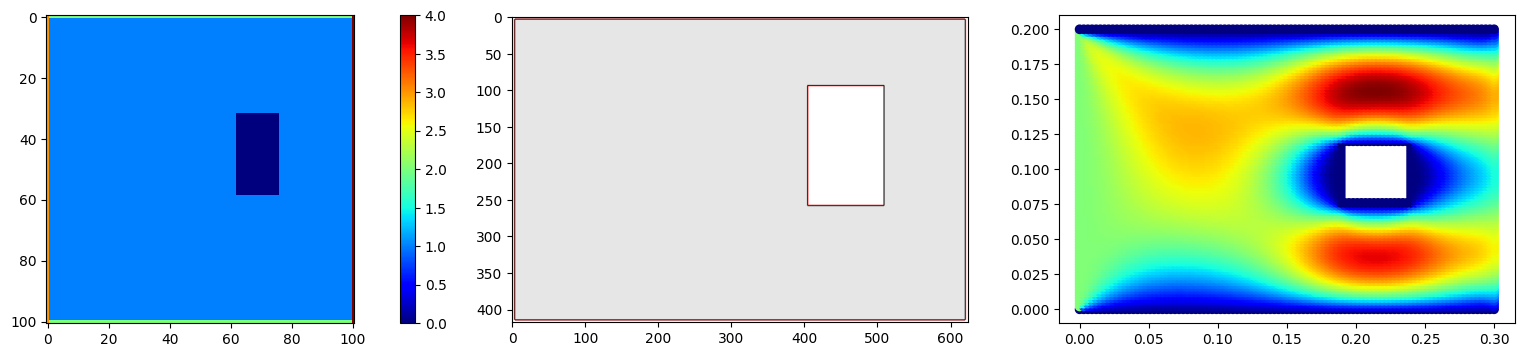

In [12]:
IDX = 0

# Boundary
boundary = np.array(scipy.io.loadmat(BOUNDARY_PATH+boundary_lst[IDX])['Boundary'])
boundary = np.where(boundary==5,0,boundary)
plt.figure(figsize=[20,4])
plt.subplot(1,3,1)
plt.imshow(boundary,cmap='jet')
plt.colorbar(fraction=0.046, pad=0.1)

# Subd
subd = cv2.imread(SUBD_PATH+subd_data_lst[IDX])
plt.subplot(1,3,2)
plt.imshow(subd)

# Solve Result
solve = pd.read_csv(SOLVE_PATH+solve_data_lst[IDX])
plt.subplot(1,3,3)
plt.scatter(solve["x"],solve["y"],c=solve["ux"],cmap='jet')#, vmin=0, vmax=10)

### Generate In/Out Dataset

In [14]:
diff_x = (np.max(solve['x'])-np.min(solve['x']))/(boundary.shape[0]-1)
diff_y = (np.max(solve['y'])-np.min(solve['y']))/(boundary.shape[1]-1)
x_range = np.round(np.arange(0,0.3001,diff_x),3)
y_range = np.round(np.arange(0,0.2001,diff_y),3)
x_min, x_max = np.min(x_range), np.max(x_range)
y_min, y_max = np.min(y_range), np.max(y_range)
insert_x_lst = []
insert_y_lst = []
insert_ux_lst = []
insert_uy_lst = []
insert_p_lst = []
boundary_lst = []

solve_path = "dataset/raw/Solve/"
solve_data_lst = os.listdir(solve_path)

for solve_data in tqdm(solve_data_lst):
    solve = pd.read_csv(solve_path+solve_data)
    insert_x_lst = []
    insert_y_lst = []
    insert_ux_lst = []
    insert_uy_lst = []
    insert_p_lst = []
    boundary_lst = []
    
    for y in y_range:
        for x in x_range:
            insert_x_lst.append(x)
            insert_y_lst.append(y)
            temp_df = solve[(solve["x"]==x) & (solve["y"]==y)]
            if x==x_min:
                boundary_lst.append(3)
                insert_ux_lst.append(temp_df['ux'].values[0])
                insert_uy_lst.append(temp_df['uy'].values[0])
                insert_p_lst.append(temp_df['p'].values[0])
            elif x==x_max:
                boundary_lst.append(4)
                insert_ux_lst.append(temp_df['ux'].values[0])
                insert_uy_lst.append(temp_df['uy'].values[0])
                insert_p_lst.append(temp_df['p'].values[0])            
            elif y==y_min:
                boundary_lst.append(2)
                insert_ux_lst.append(temp_df['ux'].values[0])
                insert_uy_lst.append(temp_df['uy'].values[0])
                insert_p_lst.append(temp_df['p'].values[0])            
            elif y==y_max:
                boundary_lst.append(2)
                insert_ux_lst.append(temp_df['ux'].values[0])
                insert_uy_lst.append(temp_df['uy'].values[0])
                insert_p_lst.append(temp_df['p'].values[0])            
            else:
                try:
                    insert_ux_lst.append(temp_df['ux'].values[0])
                    insert_uy_lst.append(temp_df['uy'].values[0])
                    insert_p_lst.append(temp_df['p'].values[0])
                    boundary_lst.append(1)  
                except:
                    insert_ux_lst.append(0)
                    insert_uy_lst.append(0)
                    insert_p_lst.append(0)
                    boundary_lst.append(0)
                    
    new_df = pd.DataFrame({"x":insert_x_lst,"y":insert_y_lst,"ux":insert_ux_lst,"uy":insert_uy_lst,"p":insert_p_lst,'boundary':boundary_lst})
    new_df.to_csv(f"dataset/preprocessed/{solve_data}",index=False)                                      

100%|██████████| 2/2 [00:06<00:00,  3.10s/it]


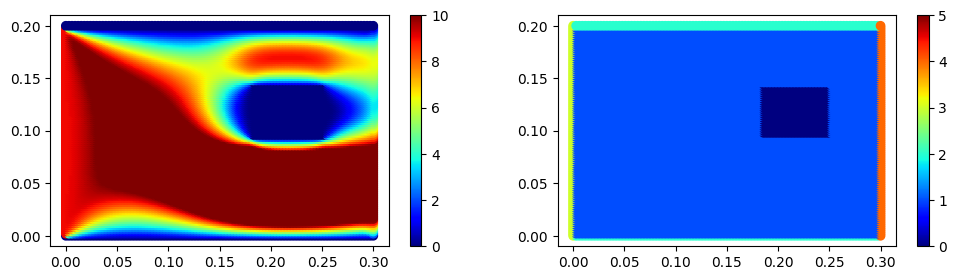

In [65]:
plt.figure(figsize=[12,3])
plt.subplot(1,2,1)
plt.scatter(new_df["x"],new_df["y"],c=new_df["ux"],cmap='jet', vmin=0, vmax=10)
plt.colorbar()
plt.subplot(1,2,2)
plt.scatter(new_df["x"],new_df["y"],c=new_df["boundary"],cmap='jet', vmin=0, vmax=5)
plt.colorbar()

### Generate Operation Vocabulary

In [8]:
filenames = sorted(os.listdir(Config.PREPROCESSED_PATH))
filenames = [i.strip(".csv") for i in filenames]
ux_set = list(set([int(i.split("_")[2]) for i in filenames]))
uy_set = list(set([int(i.split("_")[4]) for i in filenames]))
vocab_list = Config.MARKER + list(set(ux_set+uy_set))
char2idx = {char:idx for idx, char in enumerate(vocab_list)}
idx2char = {idx:char for idx, char in enumerate(vocab_list)}

In [8]:
import json
with open('configs/char2idx.json', 'w') as json_file:
    json.dump(char2idx, json_file, indent=4, ensure_ascii=False)
with open('configs/idx2char.json', 'w') as json_file:
    json.dump(idx2char, json_file, indent=4, ensure_ascii=False)